# RoBERTa-based Text Classification Model
This proof-of-concept project was developed using Google Colab to create a RoBERTa-based text classification model for social media content regulation. The model is designed to filter and flag online posts, providing predictions and actionable recommendations for human moderators. These recommendations include options such as approving the content, adding a warning label, or suggesting removal. The model streamlines the content review process by offering detailed metrics and recommendations, aiding moderators in making faster and more informed decisions.

## Loading and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import re
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification
from torch.nn import CrossEntropyLoss

from transformers import AdamW
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns


# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
file_path = '/content/drive/My Drive/Ethics of AI/labeled_data.csv'
df = pd.read_csv(file_path)
df.head()

,index,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
# Define preprocessing function
def preprocess_text(text):
    # Remove usernames
    text = re.sub(r'@\w+', '', text)
    # Remove links
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove "RT" markers
    text = re.sub(r'\bRT\b', '', text)
    # Remove special characters (except apostrophes)
    text = re.sub(r"[^\w\s']", '', text)
    # Remove short words (<3 characters)
    text = ' '.join([word for word in text.split() if len(word) > 2])

    # Tokenize words
    words = word_tokenize(text)

    # Apply lemmatization
    lemmatized = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(lemmatized)

# Apply preprocessing to the "tweet" column
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)
df.head()

,index,count,hate_speech,offensive_language,neither,class,tweet,cleaned_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman you should n't complain about cleaning y...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad for cuffin dat hoe th...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Dawg You ever fuck bitch and she start cry You...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,The shit you hear about might true might faker...


In [5]:
# Create a new DataFrame with only the specified columns
cleaned_data = df.copy()
cleaned_data = df[['hate_speech', 'offensive_language', 'neither', 'class', 'cleaned_tweet']]

cleaned_data.head()

,hate_speech,offensive_language,neither,class,cleaned_tweet
0,0,0,3,2,woman you should n't complain about cleaning y...
1,0,3,0,1,boy dat coldtyga dwn bad for cuffin dat hoe th...
2,0,3,0,1,Dawg You ever fuck bitch and she start cry You...
3,0,2,1,1,she look like tranny
4,0,6,0,1,The shit you hear about might true might faker...


In [6]:
# Add a token length column
cleaned_data = cleaned_data.copy()
cleaned_data.loc[:,'token_length'] = cleaned_data['cleaned_tweet'].apply(lambda x: len(x.split()))

cleaned_data.head()

,hate_speech,offensive_language,neither,class,cleaned_tweet,token_length
0,0,0,3,2,woman you should n't complain about cleaning y...,18
1,0,3,0,1,boy dat coldtyga dwn bad for cuffin dat hoe th...,12
2,0,3,0,1,Dawg You ever fuck bitch and she start cry You...,12
3,0,2,1,1,she look like tranny,4
4,0,6,0,1,The shit you hear about might true might faker...,14


In [7]:
# Check the distribution of labels
class_distribution = cleaned_data['class'].value_counts()
print(class_distribution)

# Normalize to see proportions
class_distribution_normalized = cleaned_data['class'].value_counts(normalize=True)
print(class_distribution_normalized)

#0-hate speech 1-offensive language 2-neither

class
1    19190
2     4163
0     1430
Name: count, dtype: int64
class
1    0.774321
2    0.167978
0    0.057701
Name: proportion, dtype: float64


In [8]:
# Remove missing or empty tweets
cleaned_data = cleaned_data.copy()
cleaned_data = cleaned_data[cleaned_data['cleaned_tweet'].str.strip() != '']
cleaned_data.dropna(subset=['cleaned_tweet'], inplace=True)
cleaned_data.reset_index(drop=True, inplace=True)

In [9]:
# Check the distribution of labels
class_distribution = cleaned_data['class'].value_counts()
print(class_distribution)

# Normalize to see proportions
class_distribution_normalized = cleaned_data['class'].value_counts(normalize=True)
print(class_distribution_normalized)

#0-hate speech 1-offensive language 2-neither

class
1    19181
2     4156
0     1425
Name: count, dtype: int64
class
1    0.774614
2    0.167838
0    0.057548
Name: proportion, dtype: float64


In [10]:
# Number of rows before dropping duplicates
original_count = len(cleaned_data)

# Drop duplicates
cleaned_data = cleaned_data.drop_duplicates(subset=['cleaned_tweet']).reset_index(drop=True)

# Number of rows after dropping duplicates
new_count = len(cleaned_data)

# Number of duplicates removed
duplicates_removed = original_count - new_count
print(f"Number of duplicates removed: {duplicates_removed}")

Number of duplicates removed: 709


## Splitting the data

In [11]:
# features (X) and labels (y)
X = cleaned_data['cleaned_tweet']
y = cleaned_data['class']

# (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

# Combine into new DataFrames
train_data = pd.DataFrame({'cleaned_tweet': X_train, 'class': y_train})
test_data = pd.DataFrame({'cleaned_tweet': X_test, 'class': y_test})

print(f"Training data: {train_data.shape[0]} samples")
print(f"Test data: {test_data.shape[0]} samples")

overlap = set(X_train).intersection(set(X_test))
print(f"Overlap between train and test sets: {len(overlap)} samples")

Training data: 19242 samples
Test data: 4811 samples
Overlap between train and test sets: 0 samples


In [12]:
train_data['cleaned_tweet'].apply(lambda x: len(x.split())).describe()

,cleaned_tweet
count,19242.000000
mean,10.409885
std,5.384447
min,1.000000
25%,6.000000
50%,10.000000
75%,14.000000
max,28.000000


## Tokenization and Encoding

In [13]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the training data
train_encodings = tokenizer(
    list(train_data['cleaned_tweet']),
    max_length=50,
    truncation=True,
    padding=True,
    return_tensors='pt'
)

# Tokenize the test data
test_encodings = tokenizer(
    list(test_data['cleaned_tweet']),
    max_length=50,
    truncation=True,
    padding=True,
    return_tensors='pt'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
# Convert labels to tensors
train_labels = torch.tensor(list(train_data['class']))
test_labels = torch.tensor(list(test_data['class']))

In [15]:
# Create TensorDatasets for train and test data
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

In [16]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

## Build the Model

In [17]:
# Load pre-trained RoBERTa-Large model with 3 output labels for ternary classification
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-large',
    num_labels=3,  # Ternary classification
    hidden_dropout_prob=0.1  # Set dropout to 0.1
)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Confirm device
print(f"Model is running on: {device}")

# Define the Adam optimizer without gradient clipping
optimizer = AdamW(model.parameters(), lr=2e-5)


from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Loss function
loss_fn = CrossEntropyLoss()

# Define DataLoaders with the specified batch size of 8k
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
epochs = 5

# Training loop
def train_model(model, train_loader, optimizer, loss_fn, device, num_epochs=epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Unpack the batch; adjust based on your dataset's return format
            input_ids, attention_mask, labels = batch

            # Move data to the device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track total loss
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss}")


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model is running on: cuda


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train the Model

In [18]:
%%time
# Train the model
train_model(model, train_loader, optimizer, loss_fn, device, num_epochs=epochs)

Epoch 1/5: 100%|██████████| 602/602 [08:56<00:00,  1.12it/s]


Epoch 1 - Loss: 0.32997192376203516


Epoch 2/5: 100%|██████████| 602/602 [08:55<00:00,  1.12it/s]


Epoch 2 - Loss: 0.2574435979053626


Epoch 3/5: 100%|██████████| 602/602 [08:55<00:00,  1.12it/s]


Epoch 3 - Loss: 0.23154129819369


Epoch 4/5: 100%|██████████| 602/602 [08:55<00:00,  1.12it/s]


Epoch 4 - Loss: 0.20932424786590362


Epoch 5/5: 100%|██████████| 602/602 [08:56<00:00,  1.12it/s]

Epoch 5 - Loss: 0.18531018775884694
CPU times: user 22min 19s, sys: 21min 47s, total: 44min 6s
Wall time: 44min 39s


## Save the model to Google Drive

In [19]:
# Save the state_dict of the trained model
torch.save(model.state_dict(), '/content/trained_model.pth')

In [20]:
# Copy the path to Google Drive
!cp /content/trained_model.pth '/content/drive/My Drive/Ethics of AI/Model Path/'

## Reloading the model

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
# Run only if file exists in runtime
import os
# Remove the model file from runtime
os.remove('/content/trained_model.pth')

In [23]:
# Copy the model file back to runtime
!cp '/content/drive/My Drive/Ethics of AI/Model Path/trained_model.pth' /content/

# Verify the file is now in the runtime
!ls /content/

drive  sample_data  trained_model.pth


## Evaluate the Model

In [24]:
def evaluate_model(model, test_loader, device):
    model = model.to(device)  # Ensure model is on the correct device
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Ensure batch tensors are on the correct device
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

            # Get predictions
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Update correct predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Evaluation Accuracy: {accuracy * 100:.2f}%")

    return predictions, true_labels

In [25]:
# Evaluate the model on the test set
predictions, true_labels = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]

Evaluation Accuracy: 91.21%


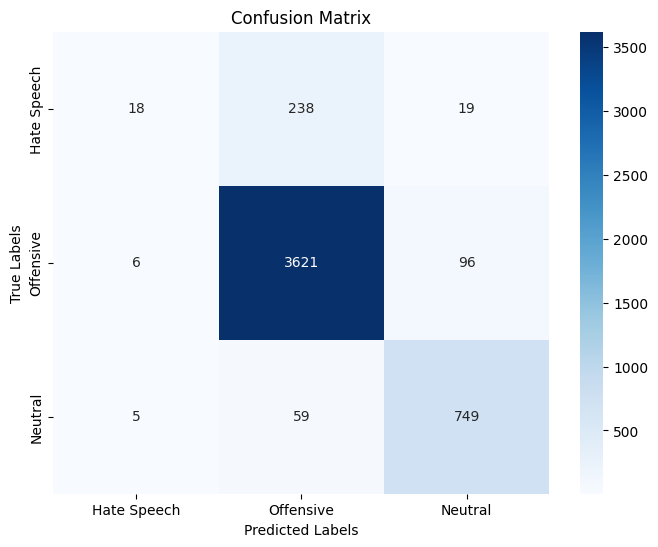

In [26]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hate Speech", "Offensive", "Neutral"], yticklabels=["Hate Speech", "Offensive", "Neutral"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Generate the classification report
report = classification_report(true_labels, predictions, target_names=["Hate Speech", "Offensive", "Neutral"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 Hate Speech       0.62      0.07      0.12       275
   Offensive       0.92      0.97      0.95      3723
     Neutral       0.87      0.92      0.89       813

    accuracy                           0.91      4811
   macro avg       0.80      0.65      0.65      4811
weighted avg       0.90      0.91      0.89      4811



## Recommendation setup

In [28]:
def classify_text_with_recommendation(model, tokenizer, text, device):
    # Preprocess the text
    inputs = tokenizer(
        text,
        max_length=28,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Move inputs to the correct device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set model to evaluation mode
    model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1).squeeze()

    # Get the predicted class
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map numeric label to string label
    label_map = {0: "Hate Speech", 1: "Offensive", 2: "Neutral"}
    predicted_label = label_map[predicted_class]

    # Get the probability of the predicted class
    predicted_prob = probabilities[predicted_class].item()

    # Define thresholds for decisions
    HIGH_CONFIDENCE = 0.75
    MEDIUM_CONFIDENCE = 0.50

    # Determine action based on predicted class and confidence
    if predicted_label == "Hate Speech":
        if predicted_prob >= HIGH_CONFIDENCE:
            recommendation = "Remove Post"
        elif predicted_prob >= MEDIUM_CONFIDENCE:
            recommendation = "Add Warning: 'May contain hateful content'"
        else:
            recommendation = "Moderation Required"
    elif predicted_label == "Offensive":
        if predicted_prob >= HIGH_CONFIDENCE:
            recommendation = "Add Warning: 'May contain offensive material'"
        elif predicted_prob >= MEDIUM_CONFIDENCE:
            recommendation = "Moderation Required"
        else:
            recommendation = "Allow Post"
    else:  # Neutral
        recommendation = "Allow Post"

    # Format results
    metrics = {
        "text": text,
        "predicted_label": predicted_label,
        "probabilities": {label_map[i]: f"{round(probabilities[i].item() * 100, 2)}%" for i in range(len(label_map))},
        "recommendation": recommendation
    }
    return metrics


## Testing the model on inputed text

In [29]:
# Example text
text = "@michaelpalmer is the best teacher at Maryville University!"

# Classify the text and get a recommendation
metrics = classify_text_with_recommendation(model, tokenizer, text, device)

# Print the metrics and recommendation
print("=== Classification and Recommendation ===")
print(f"Text: {metrics['text']}")
print(f"Predicted Label: {metrics['predicted_label']}")
print("\nProbabilities:")
for label, value in metrics['probabilities'].items():
    print(f"  {label}: {value}")
print(f"\nRecommendation: {metrics['recommendation']}")

=== Classification and Recommendation ===
Text: @michaelpalmer is the best teacher at Maryville University!
Predicted Label: Neutral

Probabilities:
  Hate Speech: 0.37%
  Offensive: 1.44%
  Neutral: 98.19%

Recommendation: Allow Post


In [30]:
# Example text
text = "I hate people who hate people!"

# Classify the text and get a recommendation
metrics = classify_text_with_recommendation(model, tokenizer, text, device)

# Print the metrics and recommendation
print("=== Classification and Recommendation ===")
print(f"Text: {metrics['text']}")
print(f"Predicted Label: {metrics['predicted_label']}")
print("\nProbabilities:")
for label, value in metrics['probabilities'].items():
    print(f"  {label}: {value}")
print(f"\nRecommendation: {metrics['recommendation']}")

=== Classification and Recommendation ===
Text: I hate people who hate people!
Predicted Label: Hate Speech

Probabilities:
  Hate Speech: 63.83%
  Offensive: 28.89%
  Neutral: 7.28%

Recommendation: Add Warning: 'May contain hateful content'


In [31]:
# Example text
text = "Go fuck yourself bitch!"

# Classify the text and get a recommendation
metrics = classify_text_with_recommendation(model, tokenizer, text, device)

# Print the metrics and recommendation
print("=== Classification and Recommendation ===")
print(f"Text: {metrics['text']}")
print(f"Predicted Label: {metrics['predicted_label']}")
print("\nProbabilities:")
for label, value in metrics['probabilities'].items():
    print(f"  {label}: {value}")
print(f"\nRecommendation: {metrics['recommendation']}")

=== Classification and Recommendation ===
Text: Go fuck yourself bitch!
Predicted Label: Offensive

Probabilities:
  Hate Speech: 14.71%
  Offensive: 85.21%
  Neutral: 0.08%

Recommendation: Add Warning: 'May contain offensive material'
